In [1]:
import duckdb
duckdb.__version__

'0.9.1'

In [62]:
local_con = duckdb.connect("./output/clean_data.duckdb") 

In [64]:
local_con.sql("LOAD motherduck")

In [66]:
con.sql("ATTACH './output/clean_data.duckdb'")

In [86]:
con.sql("SHOW DATABASES").show()

┌───────────────┐
│ database_name │
│    varchar    │
├───────────────┤
│ clean_data    │
│ my_db         │
│ sample_data   │
└───────────────┘



In [88]:
#attaching 
con.sql("ATTACH './output/clean_data.duckdb'") 

BinderException: Binder Error: Database "./output/clean_data.duckdb" is already attached with alias "clean_data"

In [85]:
# for deleting database and all its share data
con.sql("DROP DATABASE clouddb CASCADE")

In [1]:
%load_ext sql

In [2]:
%sql duckdb:///output/clean_data.duckdb

Connecting to 'duckdb:///output/clean_data.duckdb'

In [5]:
%sql df << SELECT * FROM 'java_data' 
data = df.DataFrame()
data.head(1)

Running query in 'duckdb:///output/clean_data.duckdb'

,refresh_date,region_name,score,term,rank,group_in_rank,percent_gain
0,2023-09-20,Banten,30.0,gmail,17,1,80


In [6]:
# Imputation using mode value for score column
mode_value = data['score'].mode()[0]
data['score'].fillna(mode_value, inplace=True)
data.isna().sum()

refresh_date     0
region_name      0
score            0
term             0
rank             0
group_in_rank    0
percent_gain     0
dtype: int64

In [7]:
data.region_name.unique()

array(['Banten', 'Special Region of Yogyakarta',
       'Special Capital Region of Jakarta', 'Central Java', 'West Java',
       'East Java', 'Bali'], dtype=object)

In [8]:
data.head(1)

,refresh_date,region_name,score,term,rank,group_in_rank,percent_gain
0,2023-09-20,Banten,30.0,gmail,17,1,80


In [9]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Making the datetime into the correct format
data['refresh_date'] = pd.to_datetime(data['refresh_date'])
data['year'] = data['refresh_date'].dt.year
data['month'] = data['refresh_date'].dt.month
data['day'] = data['refresh_date'].dt.day


<Axes: ylabel='month,region_name'>

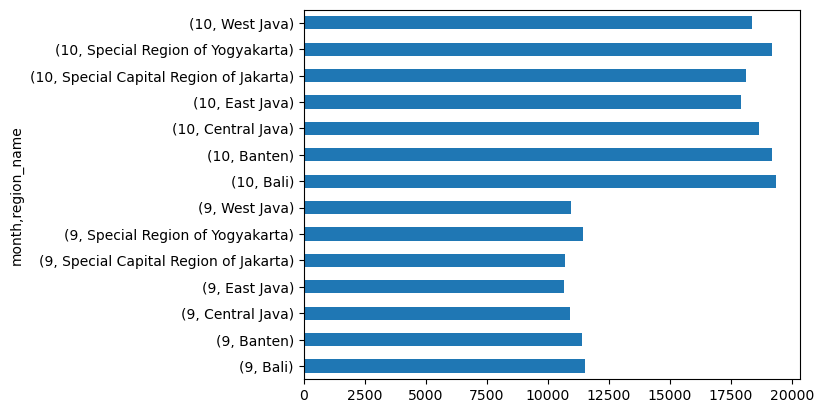

In [11]:
# Checking the data from each region in different dates

data.groupby(['month','region_name']).size().plot(kind='barh')

# In general, there are more data in month 9 compared to 10

In [12]:
data.head(1)

,refresh_date,region_name,score,term,rank,group_in_rank,percent_gain,year,month,day
0,2023-09-20,Banten,30.0,gmail,17,1,80,2023,9,20


In [13]:
# Checking the top terms in all region
top10_data = data.groupby('term').size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(10).sort_values(by='Count')#.plot(x='term',y='Count',kind='barh')
top10_data

,term,Count
222,liverpool,2507
194,keluaran sgp,2515
212,liga champions,2760
93,data sgp,2819
324,quizizz,2887
275,paito sgp,2896
279,pengeluaran sgp,2913
286,persib,3330
214,liga inggris,3439
218,live draw sgp,4581


In [14]:
# Now we want to see how each term behave in two months across different regions in Java-Bali
top10 = top10_data.term.values.tolist()
filtered_data = data[data['term'].isin(top10)]
filtered_data.columns

Index(['refresh_date', 'region_name', 'score', 'term', 'rank', 'group_in_rank',
       'percent_gain', 'year', 'month', 'day'],
      dtype='object')

In [17]:
import plotly.express as px

def plot_overall():
    # Group by 'refresh_date' and 'term', then count 'score'
    overall_grouped = filtered_data.groupby(['refresh_date', 'term'], as_index=False).agg({'score': 'count'})

    # Create a line plot
    fig = px.line(overall_grouped, 
                  x='refresh_date', 
                  y='score', 
                  color='term',
                  title='Overall Term Scores Over Time',
                  labels={'score': 'Total Score'},
                  )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=False)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=False)

    fig.update_layout({
        'width': 800, # specify your width
        'height': 600, # specify your height
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        
    })
    fig.show()

plot_overall()

/Users/immanuelsanka/anaconda3/envs/magicalytics/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [200]:
grouped = filtered_data.groupby(['refresh_date', 'term','region_name'], as_index=False).agg({'score': 'count'})  # or 'mean' if you prefer an average

import plotly.express as px
from ipywidgets import interact

def plot_line(region):
    filtered_df = grouped[grouped['region_name'] == region]
    fig = px.line(filtered_df, 
                  x='refresh_date', 
                  y='score', 
                  color='term',
                  title=f'Term Scores Over Time for {region}',
                  labels={'score': 'Total Score'},
                  )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=False)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=False)

    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
    })
    fig.show()

regions = grouped['region_name'].unique()
interact(plot_line, region=regions)

interactive(children=(Dropdown(description='region', options=('Bali', 'Banten', 'Central Java', 'East Java', '…

<function __main__.plot_line(region)>

<Axes: xlabel='score', ylabel='term'>

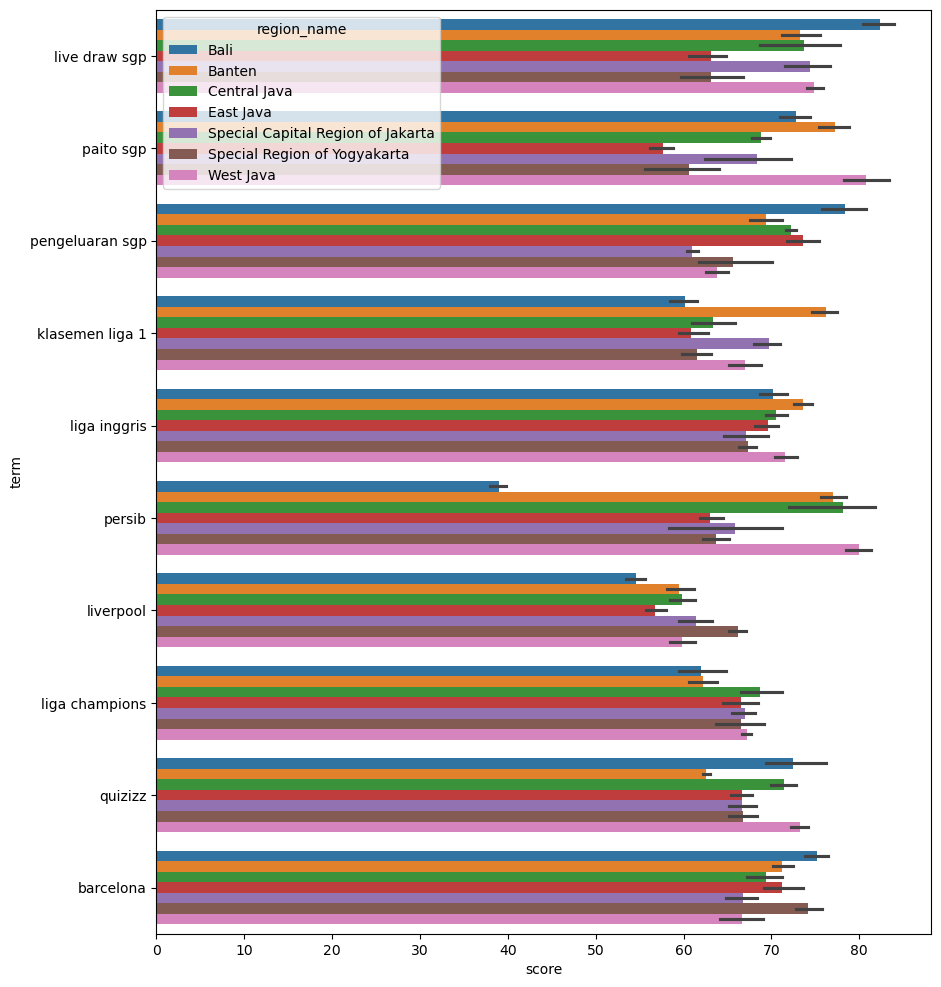

In [25]:
grouped_2 = filtered_data.groupby(['refresh_date', 'term','region_name'], as_index=False).agg({'score': 'count'})  # or 'mean' if you prefer an average
grouped_2

import seaborn as sns
plt.figure(figsize=(10,12))
sns.barplot(x='score', y='term', hue='region_name', data=grouped_2)
